In [1]:
### General analysis package
import os
import time
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### Drawing package
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
#import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # Output editable PDF text
### else
#import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # Error alert
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score

import math
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as TorchData
from torchmetrics import Accuracy
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from imblearn.over_sampling import RandomOverSampler, SMOTE

import warnings
warnings.filterwarnings('ignore')

SEED = 42
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

print("Using torch", torch.__version__)

Using torch 1.10.1


In [3]:
X_train = pd.read_csv('20220610_Results/1. X_train_SMOTE.csv', index_col=0)
X_test = pd.read_csv('20220610_Results/1. X_test.csv', index_col=0)
y_train = pd.read_csv('20220610_Results/1. y_train_SMOTE.csv', index_col=0)
y_test = pd.read_csv('20220610_Results/1. y_test.csv', index_col=0)

In [4]:
#scaler = Normalizer() # StandardScaler()
#X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
#X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [4]:
microRNA = pd.read_csv('20220610_Results/1. diff_microRNA(FC2_FDR0.05).csv', index_col=0)['ID']

In [5]:
def evaluate(clf, x, y):
    prob = clf.predict_proba(x)[:, 1]
    pred = clf.predict(x)
    auc = roc_auc_score(y, pred)
    acc = accuracy_score(y, pred)
    percision = precision_score(y, pred)
    recall = recall_score(y, pred)
    return auc, acc, percision, recall

In [7]:
clf = RandomForestClassifier(n_estimators=101, max_features=0.1)
clf.fit(X_train[microRNA], y_train)

evaluate(clf, X_train[microRNA], y_train)
evaluate(clf, X_test[microRNA], y_test)

RandomForestClassifier(max_features=0.1, n_estimators=101)

(1.0, 1.0, 1.0, 1.0)

(0.9789272624559083, 0.9805589307411907, 0.9633204633204633, 0.974609375)

In [8]:
from sklearn.feature_selection import RFECV
estimator = RandomForestClassifier(n_estimators=11)
selector = RFECV(estimator, step=1, cv=5, scoring='roc_auc', n_jobs=5)
selector = selector.fit(X_train[microRNA], y_train)
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,

In [9]:
select_microRNA = microRNA[selector.support_]
len(select_microRNA)

453

In [10]:
pd.DataFrame({'RFE':select_microRNA}).to_csv('20220610_Results/4. RF_RFE_features.csv')

In [11]:
param_grid = {'n_estimators':[101],
              'criterion': ['gini'], 
              'max_depth': [None, 2, 4, 6], 
              'max_features': [None, 0.1, 0.3, 0.5], 
              'max_samples': [None, 0.9, 0.7, 0.5],
              'class_weight': ['balanced'],
              'n_jobs': [3],
              'random_state': [SEED]
             }

tune_model = model_selection.GridSearchCV(RandomForestClassifier(), param_grid=param_grid, 
                                          scoring = 'roc_auc', cv = 5, return_train_score=True)
tune_model.fit(X_train[select_microRNA], y_train)
print('Parameters: ', tune_model.best_params_)
print("Training score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("Valid score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("Valid score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'], 'criterion': ['gini'],
                         'max_depth': [None, 2, 4, 6],
                         'max_features': [None, 0.1, 0.3, 0.5],
                         'max_samples': [None, 0.9, 0.7, 0.5],
                         'n_estimators': [101], 'n_jobs': [3],
                         'random_state': [42]},
             return_train_score=True, scoring='roc_auc')

Parameters:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.1, 'max_samples': None, 'n_estimators': 101, 'n_jobs': 3, 'random_state': 42}
Training score mean: 100.00
Valid score mean: 99.50
Valid score 3*std: +/- 0.71
----------


In [12]:
model = RandomForestClassifier(**tune_model.best_params_)
model.fit(X_train[select_microRNA], y_train)
evaluate(model, X_train[select_microRNA], y_train)
evaluate(model, X_test[select_microRNA], y_test)

RandomForestClassifier(class_weight='balanced', max_features=0.1,
                       n_estimators=101, n_jobs=3, random_state=42)

(1.0, 1.0, 1.0, 1.0)

(0.9769741374559082, 0.9793438639125152, 0.9631782945736435, 0.970703125)

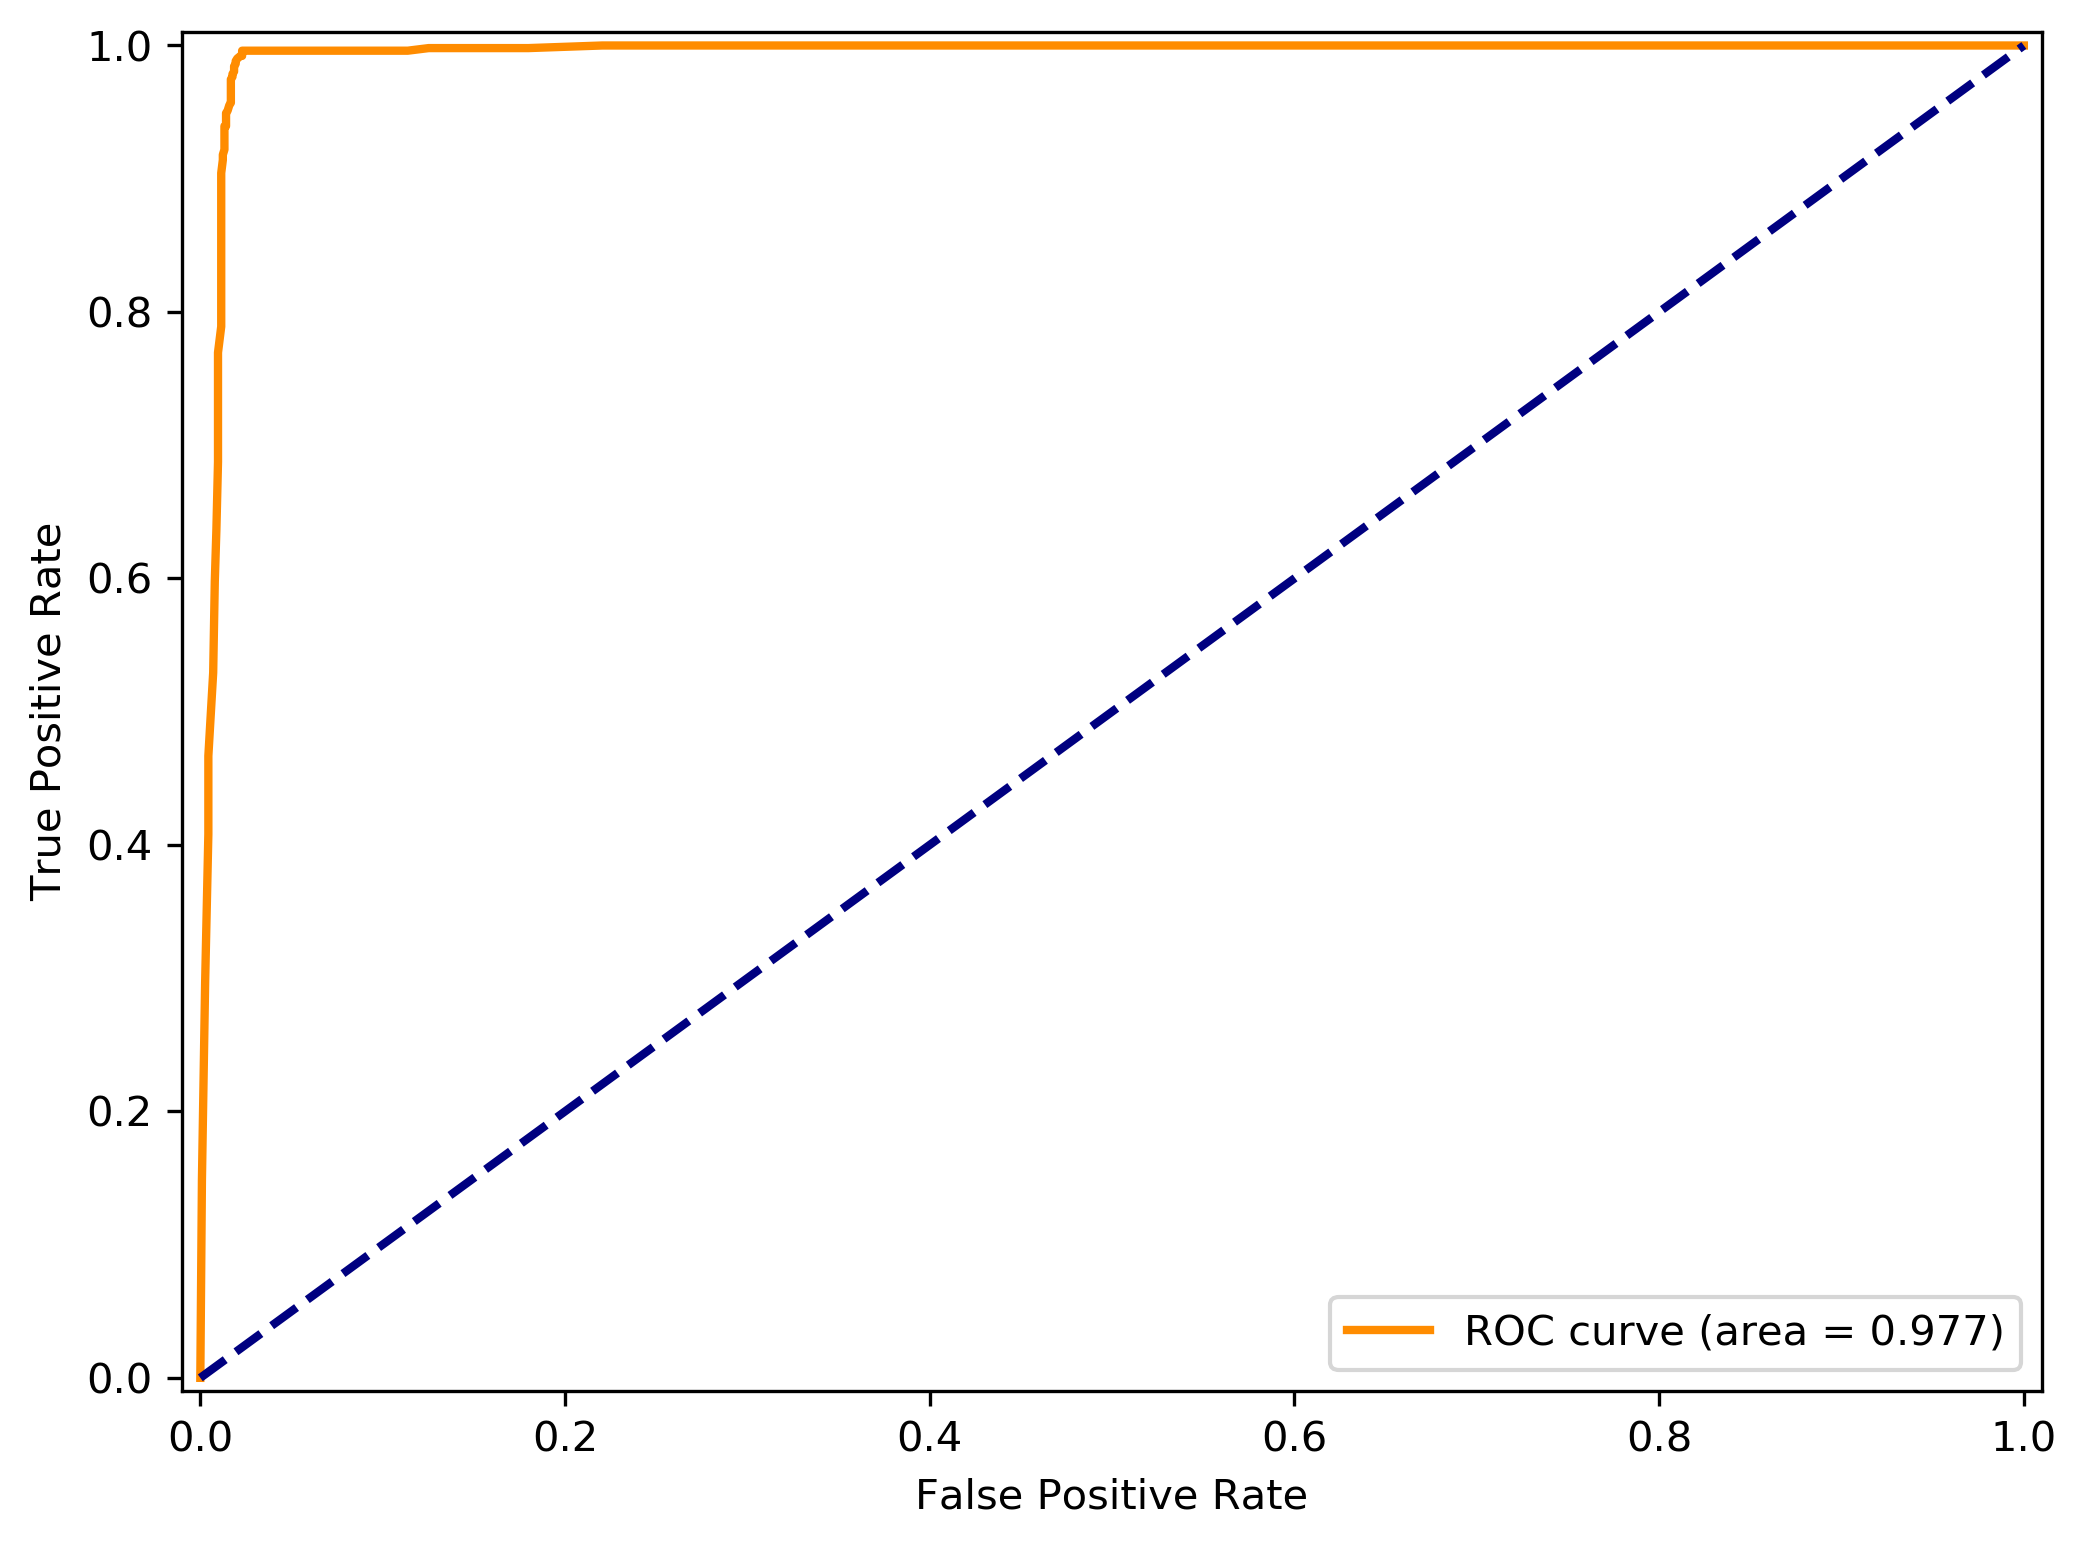

<Figure size 2400x1800 with 0 Axes>

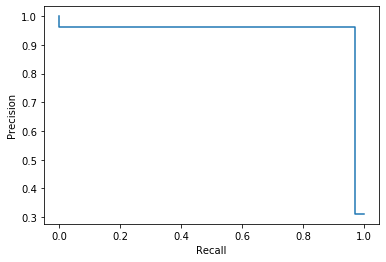

In [13]:
from sklearn import metrics
probs = model.predict_proba(X_test[select_microRNA])[:, 1]
pred = model.predict(X_test[select_microRNA])
auc = roc_auc_score(y_test, pred)


fpr, tpr, thresholds = metrics.roc_curve(y_test, probs, pos_label=1)
fig = plt.figure(figsize=(8, 6), dpi=300)
_ = plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.3f)" % auc)
_ = plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
_ = plt.xlim([-0.01, 1.01])
_ = plt.ylim([-0.01, 1.01])
_ = plt.xlabel("False Positive Rate")
_ = plt.ylabel("True Positive Rate")
_ = plt.legend(loc="lower right")
_ = plt.show()
fig.savefig('20220610_Results/4. ROC.pdf', dpi=300)

precision, recall, _ = metrics.precision_recall_curve(y_test, pred)
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
fig = plt.figure(figsize=(8, 6), dpi=300)
_ = disp.plot()

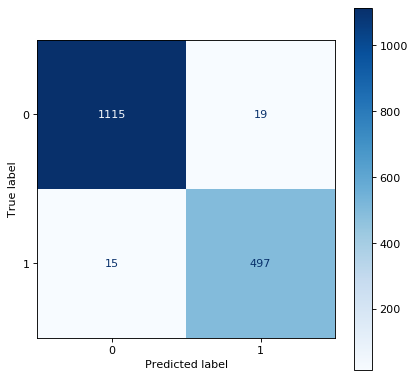

In [14]:
from sklearn.metrics import plot_confusion_matrix
fig = plt.figure(1, (6, 6), dpi=80)
ax = fig.add_subplot(1,1,1)
_ = plot_confusion_matrix(model, X_test[select_microRNA], y_test, ax=ax, cmap='Blues')
fig.savefig('20220610_Results/4. plot_confusion_matrix.pdf', dpi=300)

# External data validation

In [15]:
extenal = pd.read_csv('20220610_Results/1. GSE58606.csv', index_col=0)
len(select_microRNA), len(set(select_microRNA)&set(extenal.columns))
extenal.head(2)

(453, 319)

,hsa-miR-9-5p,hsa-miR-126-3p,hsa-miR-140-5p,hsa-miR-105-5p,hsa-miR-297,hsa-let-7i-5p,hsa-miR-130a-3p,hsa-miR-146b-5p,hsa_negative_control_6,hsa_negative_control_7,...,hsa-miR-205-3p,hsa-miR-1260a,hsa-miR-525-5p,hsa-miR-187-5p,hsa-miRPlus-A1086,hsa-miR-551b-5p,hsa-miR-300,hsa-miR-193b-5p,Label,Disease
0,6.877643,8.080215,6.245265,6.304782,6.686064,7.805950,6.814781,7.146955,6.170680,6.129586,...,7.176684,7.724408,6.035476,6.255048,6.572019,6.251777,5.873303,6.362097,1,primary breast cancer
1,6.544287,6.882722,5.874236,6.324987,6.638048,6.946567,6.488574,6.690773,6.160272,6.104929,...,7.249094,7.308890,6.021796,6.902473,6.347183,6.625569,6.004899,6.560329,1,primary breast cancer


In [16]:
temp = extenal[set(select_microRNA)&set(extenal.columns)]
for i in set(select_microRNA)-set(extenal.columns):
    temp[i] = X_train[i].mean()
temp.head(2)

,hsa-miR-4299,hsa-miR-493-3p,hsa-miR-5100,hsa-miR-140-3p,hsa-miR-4641,hsa-miR-3667-3p,hsa-miR-582-3p,hsa-miR-543,hsa-miR-3917,hsa-miR-556-5p,...,hsa-miR-627-5p,hsa-miR-7974,hsa-miR-7856-5p,hsa-miR-199a-3p;hsa-miR-199b-3p,hsa-miR-219b-5p,hsa-miR-6795-5p,hsa-miR-6874-3p,hsa-miR-6833-3p,hsa-miR-8059,hsa-miR-3192-5p
0,8.811337,5.993228,13.89165,6.790686,5.993228,6.354037,6.133947,6.299050,6.544989,5.970980,...,3.080234,3.342517,3.145038,3.187941,4.442758,6.05691,3.222012,4.133102,9.254955,3.165391
1,9.581144,6.111673,13.36454,6.388607,5.993884,6.342899,6.141563,6.260658,6.604372,5.893273,...,3.080234,3.342517,3.145038,3.187941,4.442758,6.05691,3.222012,4.133102,9.254955,3.165391


In [17]:
evaluate(model, temp[select_microRNA], extenal['Label'])

(0.5081967213114754, 0.09774436090225563, 1.0, 0.01639344262295082)

In [18]:
from sklearn.model_selection import cross_val_score
extent_model = RandomForestClassifier(**tune_model.best_params_)

cross_val_score(extent_model, extenal[set(select_microRNA)&set(extenal.columns)], extenal['Label'], 
                cv=5, scoring='roc_auc')

array([1.        , 1.        , 1.        , 0.97916667, 1.        ])